# Spelling correction model

First of all, we need some words. First we need some text, possibly from a file. Then we can break the text into words or tokens. I have a big text called .txt which I have saved in the directry of this project. We can read it, and see how many characters are there in the file.

In [26]:
# importing preliminaries
%pylab inline
import nltk
import re
import math
import string
from collections import Counter
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [27]:
TEXT = open('words.txt').read()
len(TEXT)

6127059

So, it's 61,27,059 characters.

Now let's break the text up into tokens. For now we'll ignore all the punctuation and numbers, and anything that is not a letter.

In [28]:
def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower()) 

In [29]:
tokens('Hey, I am working with NLTK..!')

['hey', 'i', 'am', 'working', 'with', 'nltk']

In [30]:
WORDS = tokens(TEXT)
len(WORDS)

1023444

So, a million words. Here are the top 10 words:

In [31]:
print(WORDS[:10])

['dan', 'morgan', 'told', 'himself', 'he', 'would', 'forget', 'ann', 'turner', 'he']


Here we are using a model that is known as "Bag of words" We know that language is very complicated, but we can create a simplified model of language that captures part of the complexity. In this model, we avoid the order of words, but carry their frequencies. Here's a function to sample an n word sentence from a bag of words:

In [32]:
def sample(bag, n=10):
    "Sample a random n-word sentence from the model described by the bag of words."
    return ' '.join(random.choice(bag) for _ in range(n))

In [33]:
sample(WORDS)

'through have is or the problem flannagan hymn floresville on'

In [34]:
Counter(tokens('Hey, this is the third exercise'))

Counter({'exercise': 1, 'hey': 1, 'is': 1, 'the': 1, 'third': 1, 'this': 1})

Another way to use this model is "Counter", which is a dictionary of {'word': count} pairs. see the below code: 

In [35]:
COUNTS = Counter(WORDS)

print (COUNTS.most_common(10))

[('the', 70003), ('of', 36473), ('and', 28935), ('to', 26247), ('a', 23517), ('in', 21422), ('that', 10789), ('is', 10109), ('was', 9815), ('he', 9801)]


A Counter is like a dict, but with a few extra methods. one can see the differences below -

In [36]:
for w in tokens('pound is widely expected to take another sharp drive '):
    print (COUNTS[w], w)

35 pound
10109 is
52 widely
187 expected
26247 to
619 take
689 another
75 sharp
112 drive


linguist 'George Zipf' Doctorate from Harvard, noted that in any big text file, the nth most frequent word appears with a frequency of about 1/n. He is the enventor of Zipf's Law. If we plot the frequency of words, most common first, on a log-log plot, they should come out as a straight line if Zipf's Law holds. Here we see that it is a fairly close fit: 

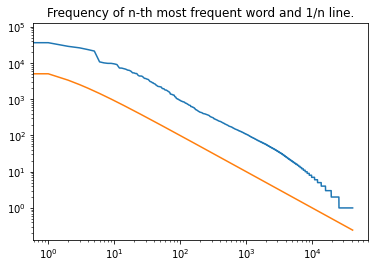

In [37]:
M = COUNTS['is']
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)]);

Given a word w, find the most likely correction c = correct(w).

Approach: Try all candidate words c that are known words that are near w. Choose the most likely one.

How to balance near and likely?

For this time we always prefer nearer, but when there is a tie on nearness, then the program use the word with the highest WORDS count. to Measure nearness we are going to use edit distance.I have determined that going out to edit distance 2 will give us reasonable results. Then we can define correct(w)

In [38]:
def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

The functions known and edits0 are easy; and edits2 is easy if we assume we have edits1

In [39]:
def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

Now for edits1(word): the set of candidate words that are one edit away. For example, given "speech", this would include "sepech"and also "spechz". One can see this in the code below in(print (edits1('speech')) Then How could we detect them? One way is to split the original word in all possible places, each split forming a pair of words, (a, b), before and after the place, and at each place, either delete, transpose, replace, or insert a letter.

In [40]:
def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [41]:
splits('speech')

[('', 'speech'),
 ('s', 'peech'),
 ('sp', 'eech'),
 ('spe', 'ech'),
 ('spee', 'ch'),
 ('speec', 'h'),
 ('speech', '')]

In [42]:
print (edits0('speech'))

{'speech'}


In [43]:
print (edits1('speech'))

{'speechr', 'splech', 'spueech', 'speeih', 'speecf', 'spfeech', 'slpeech', 'speeclh', 'gpeech', 'speecb', 'mspeech', 'bspeech', 'skeech', 'speechv', 'shpeech', 'speechl', 'speechn', 'speecw', 'spetch', 'sppech', 'hpeech', 'speekh', 'sfeech', 'sphech', 'speecj', 'espeech', 'speechi', 'speecth', 'speeach', 'sneech', 'spweech', 'speedh', 'rspeech', 'speepch', 'sdeech', 'spceech', 'pspeech', 'spepech', 'spnech', 'speemch', 'speebh', 'spbeech', 'speemh', 'speerch', 'speefch', 'scpeech', 'spveech', 'ispeech', 'speeuch', 'speecmh', 'sbpeech', 'peech', 'sgpeech', 'spyech', 'sfpeech', 'speeoch', 'speecd', 'speetch', 'spegech', 'spejech', 'speceh', 'sptech', 'spkech', 'speechp', 'soeech', 'szeech', 'spehech', 'speecgh', 'svpeech', 'spench', 'uspeech', 'spleech', 'sieech', 'speedch', 'sveech', 'spxeech', 'speecph', 'xspeech', 'spevch', 'steech', 'spoeech', 'opeech', 'spelch', 'speegh', 'speecbh', 'spewch', 'speqch', 'speejh', 'wspeech', 'stpeech', 'mpeech', 'tpeech', 'spmech', 'speec', 'pseech', 

In [44]:
print (len(edits2('speech')))

51013


In [45]:
map(correct, tokens('speech eis not good'))

In [46]:
def correct_text(text):
    "Correct all the words within a text, returning the corrected text."
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    "Spell-correct word in match, and preserve proper upper/lower/title case."
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    "Return the case-function appropriate for text: upper, lower, title, or just str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

In [47]:
map(case_of, ['UPPER', 'lower', 'Title', 'CamelCase'])

In [48]:
correct_text('spech is noot good')

'speech is not good'

In [49]:
correct_text('havee yoo dane thaat projecct')

'have you dane that project'

In [50]:
correct_text('Profesor is a nyce persan')

'Professor is a nice person'

Here we saw that how we can correct the miss spelled words from our text. This is one of the easiest ways to do so, hence making it simplified for our purposes. 